In [52]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import wandb
from tqdm import tqdm
import utils
from dataset import StateActionEffectDataset
import environment
import copy

run_id = "42dd84e9"

In [53]:
run = wandb.init(entity="colorslab",project="multideepsym", resume="must", id=run_id)
run = wandb.Api().run("colorslab/multideepsym/" + run_id)
model = utils.create_model_from_config(run.config)
model.load("_best", from_wandb=True)

epoch,200
train_loss,2.80586
val_loss,2.48126


In [54]:
dataset = StateActionEffectDataset("2obj", "")

In [55]:
count = 0
for e in dataset.effect:
    if torch.any(e[:,2].abs().max() > 0.1):
        count += 1
print(f"{count / len(dataset) * 100}% resulted in ds")
print(f"{count } samples")
count = 0
for e in dataset.effect:
    if np.count_nonzero(e[:,2] > 0.1) > 1:
        count += 1
print(f"{count / len(dataset) * 100}% multi object(2) movement")
print(f"{count } samples")
count = 0
for e in dataset.effect:
    if np.count_nonzero(e[:,2] > 0.1) > 2:
        count += 1
print(f"{count / len(dataset) * 100}% multi object(3) movement")
print(f"{count } samples")
count = 0
for e in dataset.effect:
    if np.count_nonzero(e[:,2] < -0.1) > 0 or np.count_nonzero(e[:,2 + 9] < -0.1) > 1:
        count += 1
print(f"{count / len(dataset) * 100}% towers falling down")
print(f"{count } samples")

94.89999999999999% resulted in ds
949 samples
30.7% multi object(2) movement
307 samples
22.900000000000002% multi object(3) movement
229 samples
30.7% towers falling down
307 samples


In [94]:
k=1

In [95]:
e = dataset[k]["effect"]
if torch.any(e[:,2].abs().max() > 0.1):
    print("effect")

effect


In [96]:
import plotly.graph_objects as go
import plotly.express as px
sample = dataset[k]
s = copy.deepcopy(sample["state"]).numpy()
s = np.concatenate( [s,np.arange(0,13,1).reshape(-1,1)], axis = 1)
extensions = []
for obj in s:
    if obj[9] > 3:
        ext = copy.deepcopy(obj)
        ext2 = copy.deepcopy(obj)
        ds = 0.125
        
        ext[0] += ds * ext[7]
        ext[1] += ds * ext[8]
        ext2[0] -= ds * ext[7]
        ext2[1] -= ds * ext[8]
        extensions.append(ext)
        extensions.append(ext2)
extensions = np.array(extensions)
s = np.concatenate([s, np.array(extensions)], axis = 0)
fig = go.Figure()
fig = px.scatter_3d(s, x = 0, y = 1, z = 2, color = 10, hover_data=[10, 9] ,labels = {"0" : "x", "1": "y", "2":"z", "9":"type", "10": "id"}, opacity = 0.7)
fig.show()
# input()

In [97]:
import plotly.graph_objects as go
import plotly.express as px
sample = dataset[k+1]
s = copy.deepcopy(sample["state"]).numpy()
s = np.concatenate( [s,np.arange(0,13,1).reshape(-1,1)], axis = 1)
extensions = []
for obj in s:
    if obj[9] > 3:
        ext = copy.deepcopy(obj)
        ext2 = copy.deepcopy(obj)
        ds = 0.125
        
        ext[0] += ds * ext[7]
        ext[1] += ds * ext[8]
        ext2[0] -= ds * ext[7]
        ext2[1] -= ds * ext[8]
        extensions.append(ext)
        extensions.append(ext2)
extensions = np.array(extensions)
s = np.concatenate([s, np.array(extensions)], axis = 0)
fig = go.Figure()
fig = px.scatter_3d(s, x = 0, y = 1, z = 2, color = 10, hover_data=[10, 9] ,labels = {"0" : "x", "1": "y", "2":"z", "9":"type", "10": "id"}, opacity = 0.7)
fig.show()
# input()

In [98]:
s = copy.deepcopy(sample["action"]).numpy()
s = np.concatenate( [np.arange(0,13,1).reshape(-1,1),s], axis = 1)
s

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 3.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 5.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 6.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 7.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 8.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 9.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [10.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [11.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [12.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.]])

In [99]:
def single_iteration_data(data):
    d = {}
    for key in ["action", "state", "effect"]:
        d[key] = data[key].unsqueeze(0).expand(-1, 13, -1)
    d["pad_mask"] = data["pad_mask"].unsqueeze(0).expand(-1, 13)
    return d

In [100]:
with torch.no_grad():
    loss, pred = model.loss_with_pred(single_iteration_data(sample))
print(loss)
pred = pred.cpu()[0]

tensor(49.4473, device='cuda:0')


In [101]:
((sample["effect"] - pred) ** 2).sum() 

tensor(49.4473)

In [107]:
x[1] , u[1]

(0.39440808, 0.0)

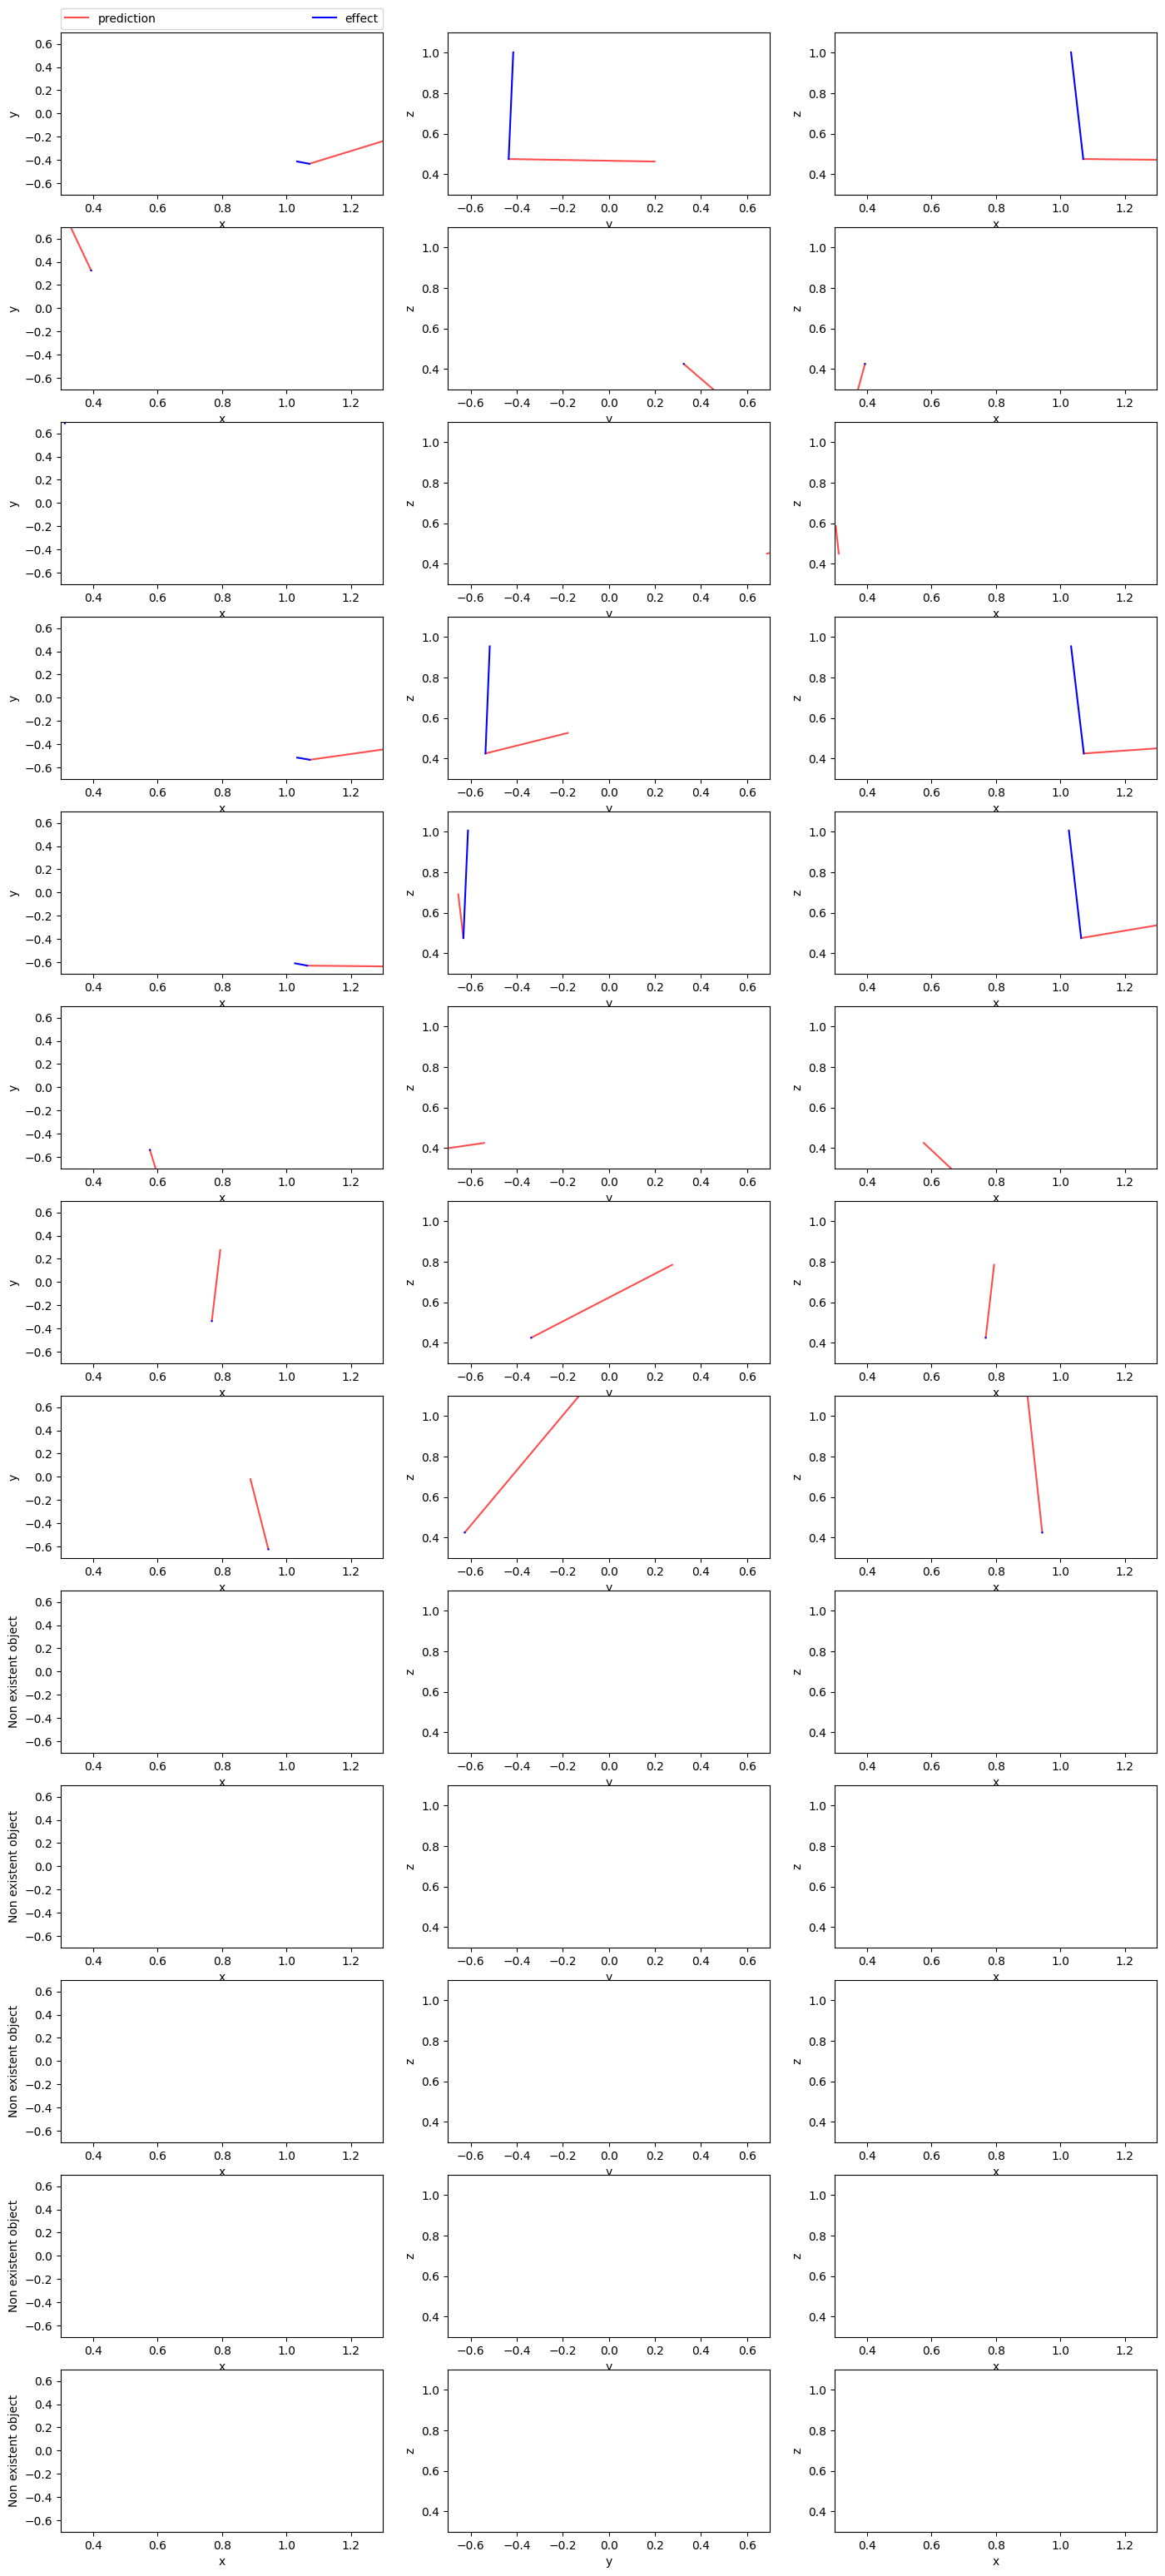

In [103]:
fig = plt.figure(figsize=( 17, 39))
xy , yz , xz = [], [], []

state = sample["state"]
effect = sample["effect"]
x, y, z =state[:, 0].numpy() ,state[:, 1].numpy() ,state[:, 2].numpy() 
u,v,w, u2, v2,w2 = effect[:,0].numpy() ,effect[:,1].numpy() ,effect[:,2].numpy() ,pred[:,0].numpy() ,pred[:,1].numpy() ,pred[:,2].numpy() 

for i in range(13):
    xy.append(fig.add_subplot( 13,3,i*3 + 1 , xlabel="x", ylabel="y" , xlim = (0.3 , 1.3) , ylim = (-0.7, 0.7)) )
    yz.append(fig.add_subplot( 13,3,i*3 + 2 , xlabel="y", ylabel="z" , xlim = (-0.7, 0.7)  , ylim = (0.3, 1.1)) )
    xz.append(fig.add_subplot( 13,3,i*3 + 3  , xlabel="x", ylabel="z", xlim = (0.3, 1.3)   , ylim = (0.3, 1.1)) )


for i in range(13):
    yz[i].plot([y[i],y[i] + v2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xz[i].plot([x[i],x[i] + u2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u2[i]],[y[i], y[i]+ v2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u[i]],[y[i], y[i]+ v[i]],  color ="b", label= "effect")
    yz[i].plot([y[i],y[i] + v[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    xz[i].plot([x[i],x[i] + u[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    if sample["pad_mask"][i] == 0:
        xy[i].set_ylabel("Non existent object")

xy[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0.)


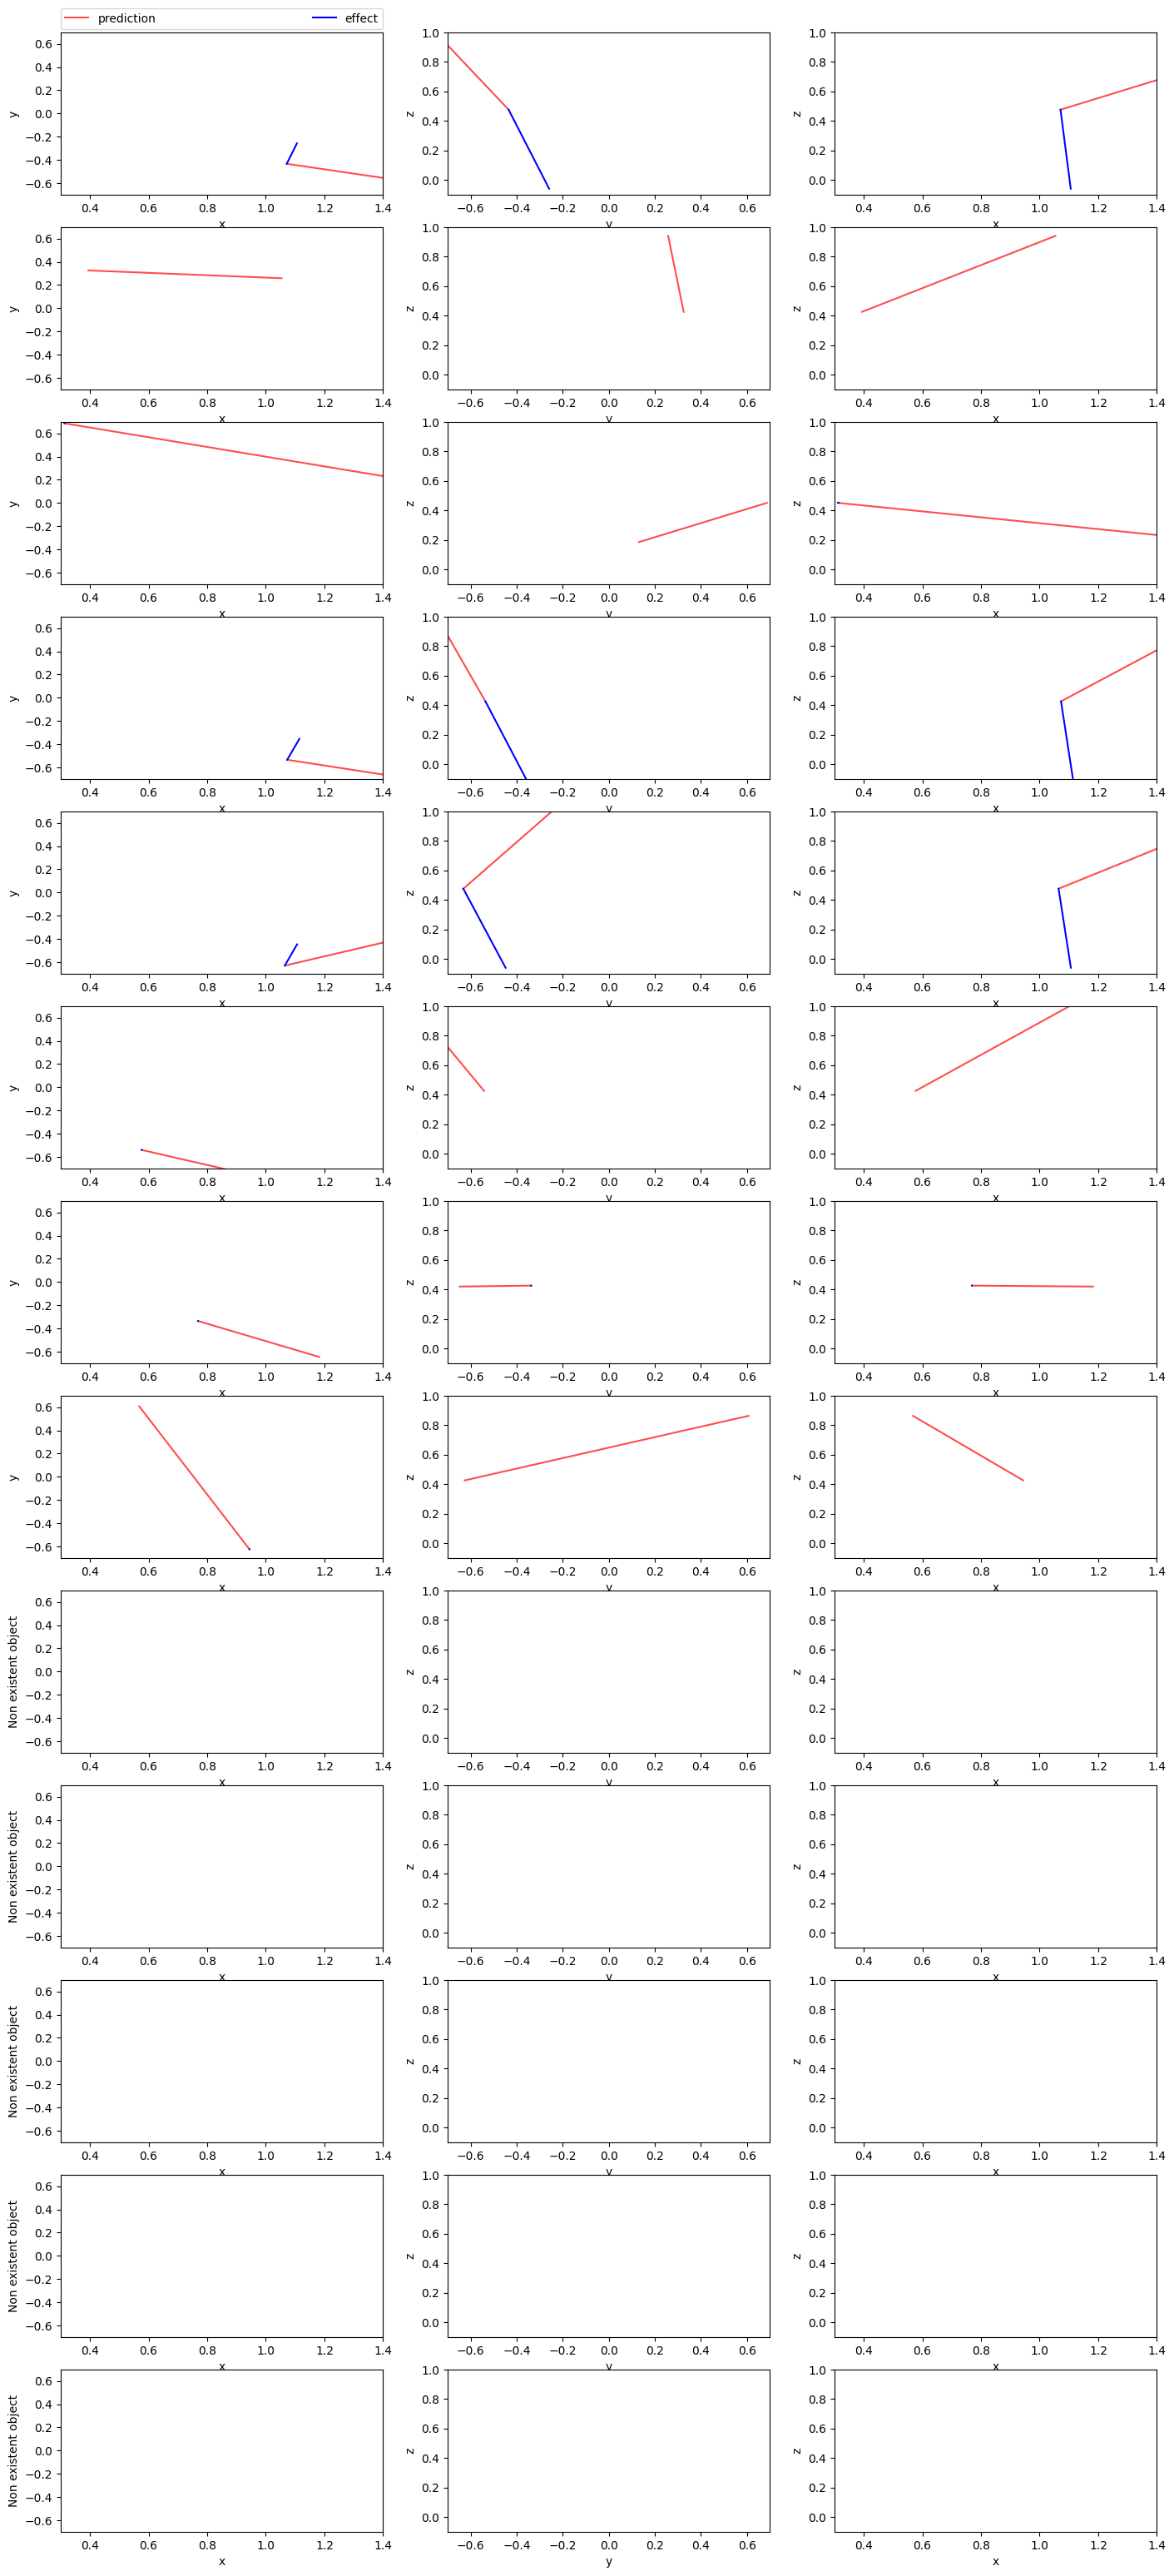

In [104]:

fig = plt.figure(figsize=( 17, 39))
xy , yz , xz = [], [], []

state = sample["state"]
effect = sample["effect"]
x, y, z =state[:, 0].numpy() ,state[:, 1].numpy() ,state[:, 2].numpy() 
u,v,w, u2, v2,w2 = effect[:,9].numpy() ,effect[:,10].numpy() ,effect[:,11].numpy() ,pred[:,9].numpy() ,pred[:,10].numpy() ,pred[:,11].numpy() 

for i in range(13):
    xy.append(fig.add_subplot( 13,3,i*3 + 1 , xlabel="x", ylabel="y" , xlim = (0.3, 1.4), ylim =(-0.7,0.7)))
    yz.append(fig.add_subplot( 13,3,i*3 + 2 , xlabel="y", ylabel="z" , xlim = (-0.7,0.7), ylim =(-0.1,1)))
    xz.append(fig.add_subplot( 13,3,i*3 + 3  , xlabel="x", ylabel="z", xlim = (0.3, 1.4), ylim =(-0.1,1)))


for i in range(13):
    yz[i].plot([y[i],y[i] + v2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xz[i].plot([x[i],x[i] + u2[i]],[z[i], z[i]+ w2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u2[i]],[y[i], y[i]+ v2[i]],color ="r", label= "prediction", alpha= 0.7)
    xy[i].plot([x[i],x[i] + u[i]],[y[i], y[i]+ v[i]],  color ="b", label= "effect")
    yz[i].plot([y[i],y[i] + v[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    xz[i].plot([x[i],x[i] + u[i]],[z[i], z[i]+ w[i]],  color ="b", label= "effect")
    if sample["pad_mask"][i] == 0:
        xy[i].set_ylabel("Non existent object")

xy[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0.)
